<a href="https://colab.research.google.com/github/rajgouravjain/dspy3/blob/master/ideas/SharePredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import seaborn as sns

import yfinance as yf
from datetime import datetime


In [ ]:
#data = yf.download('TATAMOTORS.NS',start=datetime(2021,1,1),end=datetime(2021,12,31))
df = yf.download("TATAMOTORS.NS",period='400d' , interval='60m')

[*********************100%***********************]  1 of 1 completed


In [ ]:
df= df[df['Volume'] != 0]

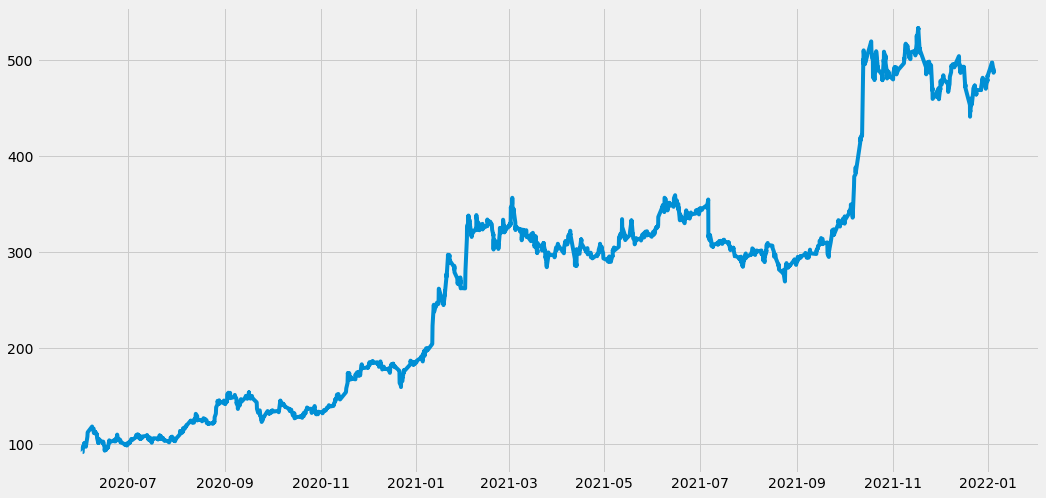

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'])


In [ ]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)

In [ ]:
training_data_len

1940

In [122]:
train_data = dataset[:training_data_len]

In [ ]:
validation_data = dataset[training_data_len:]

In [123]:
#scaling the train_test_data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_data)

In [124]:
scaled_data

array([[0.        ],
       [0.        ],
       [0.00560433],
       ...,
       [0.76013446],
       [0.7625631 ],
       [0.76331027]])

In [127]:
#train_data = scaled_data[0:training_data_len,:]
train_data = scaled_data
x_train = []
y_train = []

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  



In [128]:
x_train , y_train = np.array(x_train), np.array(y_train)

In [129]:
#reshape the x_train to 3D becase LSTM needs it that shape

x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))


In [134]:
  model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape= (x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [135]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [136]:
model.fit(x_train,y_train,batch_size=1, epochs=1)

1880/1880 [==============================] - 77s 36ms/step - loss: 0.0028


In [138]:
#test data set 

test_data = scaler.transform(validation_data)

In [149]:
x_test = []
y_test = []



In [150]:
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])
  y_test.append(test_data[i,0])


In [151]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [152]:
#prediction 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


In [153]:
rmse = np.sqrt( np.mean(predictions - y_test)**2)

In [154]:
rmse

421.9170264054595

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


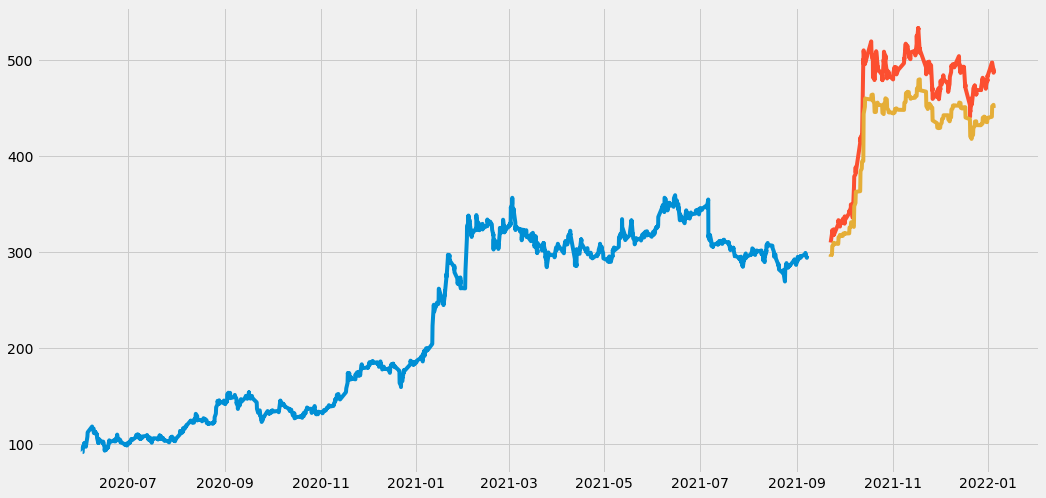

In [157]:
train = data[:training_data_len]
valid = data[training_data_len+60:]

valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.show()